## Step 1 : Construction

Build a question_reference list for further evaluatuion

In [1]:
import pandas as pd

ds = pd.read_parquet("./data/rag-test-dataset-calm-adrd.parquet")

ds.head()

,Question,Context,Answer,calm-adrd,gpt-4o-mini,gpt-4o,References,Generation
0,Can you recommend activities that are suitable...,Content: What are some tips for Finding Activi...,When looking for activities for someone with d...,I understand that finding suitable activities ...,Absolutely! Engaging individuals with dementia...,Engaging activities for individuals with demen...,[https://www.agingcare.com/articles/my-elderly...,When looking for activities for someone with d...
1,What are the benefits of hospice care for indi...,Content: How to be an effective caregiver in t...,Hospice care offers several benefits for indiv...,I understand that navigating the advanced stag...,Hospice care can provide numerous benefits for...,Hospice care can provide numerous benefits for...,[https://www.caregiver.org/resource/alzheimers...,Hospice care offers several benefits for indiv...
2,How can I navigate difficult family dynamics w...,Content: How to Handle Seemingly Manipulative ...,When navigating difficult family dynamics whil...,Navigating difficult family dynamics while car...,Caring for a loved one with Alzheimer's can be...,Navigating difficult family dynamics while car...,[https://www.agingcare.com/articles/dementia-b...,When navigating difficult family dynamics whil...
3,What are the early signs of dementia?,Content: None The early warning signs of demen...,The early signs of dementia can vary from pers...,I understand that learning about the early sig...,"Early signs of dementia can vary, but here are...",Early signs of dementia can vary between indiv...,[https://www.agingcare.com/articles/alzheimers...,The early signs of dementia can vary from pers...
4,"How does palliative care differ from hospice, ...",Content: What end-of-life care options are ava...,Palliative care and hospice care are both form...,I understand that navigating care options for ...,Palliative care and hospice care are both appr...,Palliative care and hospice care are both appr...,[https://www.agingcare.com/articles/end-stage-...,Palliative care and hospice care are both form...


In [2]:
## Constructing Question list

question_list = ds["Question"].tolist()

question_list[:10]



['Can you recommend activities that are suitable for someone with dementia to engage in and enjoy?',
 "What are the benefits of hospice care for individuals in the advanced stages of Alzheimer's disease?",
 "How can I navigate difficult family dynamics when caring for a loved one with Alzheimer's?",
 'What are the early signs of dementia?',
 'How does palliative care differ from hospice, and how can it help improve the quality of life for someone with advanced dementia?',
 "How can I ensure my loved one's safety at home, especially if they have a tendency to wander or become agitated?",
 'What activities are suitable for people with dementia, and how can I encourage participation?',
 'Are there any risk factors that can contribute to developing delirium?',
 'Are certain types of anesthesia more likely to cause delirium?',
 "How do I navigate legal issues related to caring for a loved one with Alzheimer's, such as power of attorney and guardianship?"]

In [3]:
## Prepare for parsing

import pprint
from typing import TypedDict, List

class Reference(TypedDict):
    source: str
    content: str

example_reference = """
Content: What are some tips for Finding Activities to Do with Dementia Patients? Consider the person’s interests.    The best place to start when brainstorming activities that your loved one might enjoy is taking inventory of their past and current interests and hobbies. Examples might include gardening, crafting, playing or watching sports, cooking, reading about historical events, fishing, photography, or listening to or playing certain types of music. Once you’ve made a list of potential ideas, it’s time to get creative.   Hobbies often fall by the wayside when a senior experiences increasing physical and/or mental challenges. Beth Kallmyer, former Director of Family and Information Services for the Alzheimer’s Association, recommends adjusting these pastimes to fit their abilities. Providing additional assistance and supervision is often necessary with dementia patients, but as their condition progresses, adapting the activities themselves is also required.
Source: [1] <https://www.agingcare.com/articles/my-elderly-parent-has-dementia-what-activities-can-we-do-together-137087.htm>
Content: What are some easily-modifiable activities that may be good for seniors with Alzheimer's? Stick to simple pleasures.   Keeping things simple and straightforward is often the best course of action when coming up with activities for people with Alzheimer's. Going to a local park to feed the birds and fish is an easy task that may be very fun for a person with Alzheimer's. You can also take turns reading a favorite book aloud. This can be an easy way to encourage a senior to exercise their mind while giving them the pleasure of reading a beloved book. Listen to music.   Research has shown that listening to music can help a person with Alzheimer's remember events, people, and places from their past. Additionally, music can be a way to get a senior moving through dance or song. Music can be themed to match your needs; sing along activities, upbeat motivating tunes, or relaxing sounds may all play a part in your day. Cook and clean.
Source: [2] <https://www.agingcare.com/articles/activities-for-alzheimers-148840.htm>
Content: What are some activities for Seniors with Dementia? “Activities depend on the senior’s level of dementia. Some people are still able to do things, like read, do puzzles, watch TV, tend to plants, etc., but some are not. I found that unless there is a person leading, directing and involving the patient, they may not have the insight or motivation to engage in an activity. There are activity boards that you can purchase that sit in the person’s lap or on a table and have various tasks on them, like buttons, zippers, and Velcro, and include things that have different textures and even make sounds. They are designed specifically for people with dementia and are aimed at keeping a person's hands busy and providing mental stimulation.” –Sunnygirl1
Source: [3] <https://www.agingcare.com/articles/hobbies-and-activities-for-seniors-tips-from-family-caregivers-205881.htm>
"""

def parse_context_column(context: str) -> List[Reference]:
    """Parse the context column to extract content and source.
    
    Args:
        context: The context string containing content and source information
        
    Returns:
        List[Reference]: A list of dictionaries with content and source fields
    """
    # Split the context by lines
    lines = context.strip().split('\n')
    
    references = []
    content_parts = []
    source = ""
    
    for line in lines:
        if line.startswith("Content:"):
            # If we already have content and are starting a new content section,
            # save the previous reference
            if content_parts and (source or "None" in " ".join(content_parts)):
                reference = Reference(
                    content=" ".join(content_parts),
                    source=source
                )
                references.append(reference)
                content_parts = []
                source = ""
            
            # Remove the "Content: " prefix and add to content parts
            content_parts.append(line[len("Content:"):].strip())
        elif line.startswith("Source:"):
            # Extract only the URL part from the source line
            source_line = line[len("Source:"):].strip()
            # Find the URL within angle brackets
            import re
            url_match = re.search(r'<(.*?)>', source_line)
            if url_match:
                source = url_match.group(1)
    
    # Add the last reference if there's content
    if content_parts:
        reference = Reference(
            content=" ".join(content_parts),
            source=source
        )
        references.append(reference)
    
    # If no references were found, return a single empty reference
    if not references:
        references.append(Reference(source="", content=""))
    
    return references

exp_res = parse_context_column(example_reference)

print(type(exp_res))
pprint.pprint(exp_res, indent = 4)


<class 'list'>
[   {   'content': 'What are some tips for Finding Activities to Do with '
                   'Dementia Patients? Consider the person’s interests.    The '
                   'best place to start when brainstorming activities that '
                   'your loved one might enjoy is taking inventory of their '
                   'past and current interests and hobbies. Examples might '
                   'include gardening, crafting, playing or watching sports, '
                   'cooking, reading about historical events, fishing, '
                   'photography, or listening to or playing certain types of '
                   'music. Once you’ve made a list of potential ideas, it’s '
                   'time to get creative.   Hobbies often fall by the wayside '
                   'when a senior experiences increasing physical and/or '
                   'mental challenges. Beth Kallmyer, former Director of '
                   'Family and Information Services for th

In [4]:
# Construct reference (context) list according to question

from typing import TypedDict, List

class QuestionReference(TypedDict):
    question: str
    references: list[Reference]
    
reference_list: List[QuestionReference] = []

for idx, row in ds.iterrows():
    question = row["Question"]
    references: List[Reference] = parse_context_column(row["Context"])
    
    reference_list.append(QuestionReference(question = question, references = references))

reference_list[0:3]

[{'question': 'Can you recommend activities that are suitable for someone with dementia to engage in and enjoy?',
  'references': [{'content': 'What are some tips for Finding Activities to Do with Dementia Patients? Consider the person’s interests.    The best place to start when brainstorming activities that your loved one might enjoy is taking inventory of their past and current interests and hobbies. Examples might include gardening, crafting, playing or watching sports, cooking, reading about historical events, fishing, photography, or listening to or playing certain types of music. Once you’ve made a list of potential ideas, it’s time to get creative.   Hobbies often fall by the wayside when a senior experiences increasing physical and/or mental challenges. Beth Kallmyer, former Director of Family and Information Services for the Alzheimer’s Association, recommends adjusting these pastimes to fit their abilities. Providing additional assistance and supervision is often necessary w

## Step 2: Get answer from CaLM

Now we have `reference_list` as a gold standard data to compare with, next step is to get answers from CaLM AI ADRD

In [5]:
calm_reference_list = []

for idx, row in ds.iterrows():
    calm_ref = row['References'].tolist()
    calm_reference_list.append(calm_ref)
    
calm_reference_list[:3]

In [13]:
question_list = []
question_id = []

for idx, item in enumerate(reference_list):
    question_list.append(item['question'])
    question_id.append(idx+1)

res_df = pd.DataFrame({'question_id':question_id, 'question': question_list})

res_df.head()

,question_id,question
0,1,Can you recommend activities that are suitable...
1,2,What are the benefits of hospice care for indi...
2,3,How can I navigate difficult family dynamics w...
3,4,What are the early signs of dementia?
4,5,"How does palliative care differ from hospice, ..."


In [ ]:
## Calculate recall
from tools.calculators import calculate_recall, calculate_average_precision, calculate_mrr, calculate_ndcg

recall_score_list = []
ap_score_list = []
rr_score_list = []
ndcg_score_list = []

for i, zip_item in enumerate(zip(calm_reference_list, reference_list)):
    
    pred_list, act = zip_item
    act_list = []
    for idx, ref in enumerate(act['references']):
        act_list.append(ref['source'])
    
    recall_score = calculate_recall(pred_list, act_list, 3)
    
    ap_score = calculate_average_precision(pred_list, act_list, 3)
    
    rr_score = calculate_mrr(pred_list, act_list)
    
    relevancy_list = []
    for i in range(len(pred_list)):
        pred = pred_list[i]
        act = act_list[i]
        if pred == act:
            relevancy_list.append(1)
        else:
            relevancy_list.append(0)
        
    ndcg_score = calculate_ndcg(pred_list, relevancy_list, [1,1,1], 3)
    
    recall_score_list.append(recall_score)
    
    ap_score_list.append(ap_score)
    
    rr_score_list.append(rr_score)
    
    ndcg_score_list.append(ndcg_score)
    
res_df['recall@3'] = recall_score_list
res_df['average_precision@3'] = ap_score_list
res_df['reciprocal_rank'] = rr_score_list
res_df['ndcg'] = ndcg_score_list

res_df.head()

<Figure size 1400x1000 with 0 Axes>

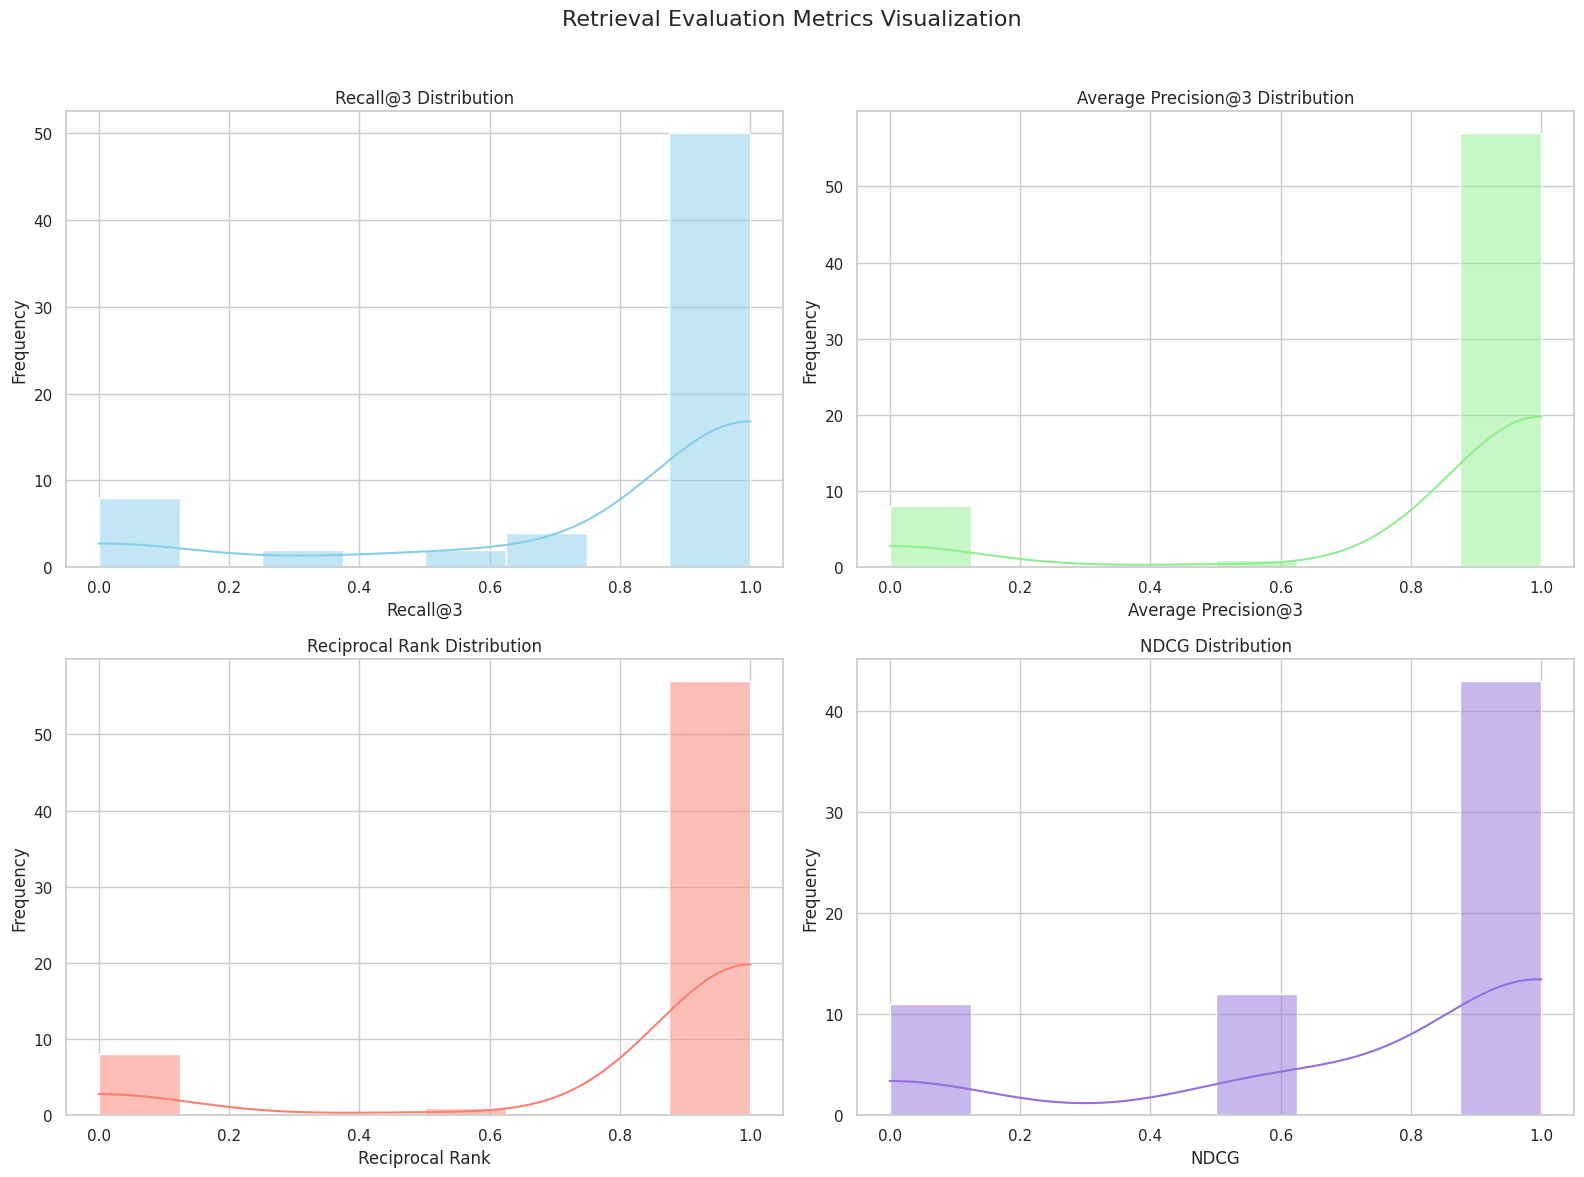

Average scores for each metric:
Average Recall@3: 0.8232
Mean Average Precision@3: 0.8712
Mean Reciprocal Rank: 0.8712
NDCG: 0.7624


/tmp/ipykernel_1730978/3237595158.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics_avg.keys()), y=list(metrics_avg.values()), palette="viridis")


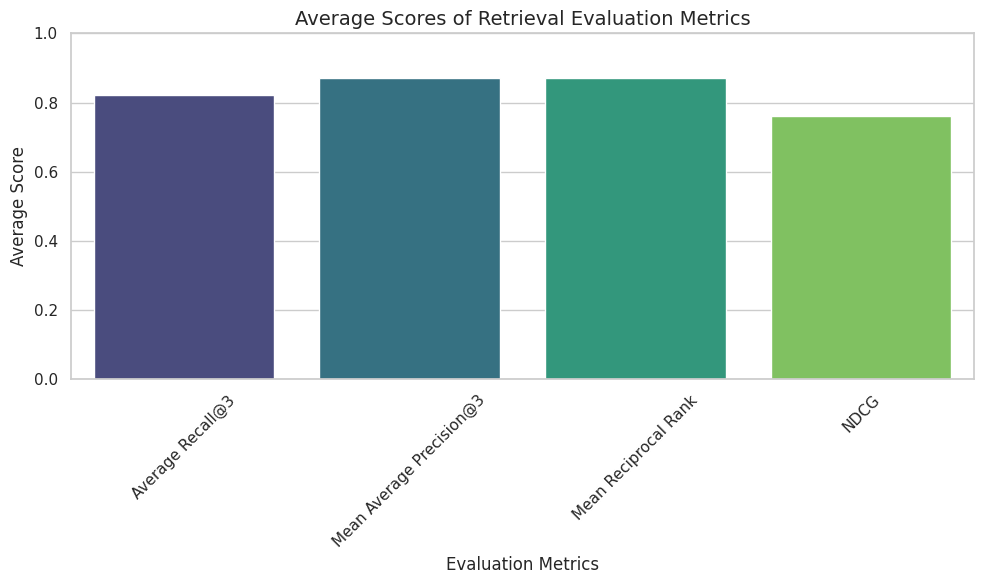

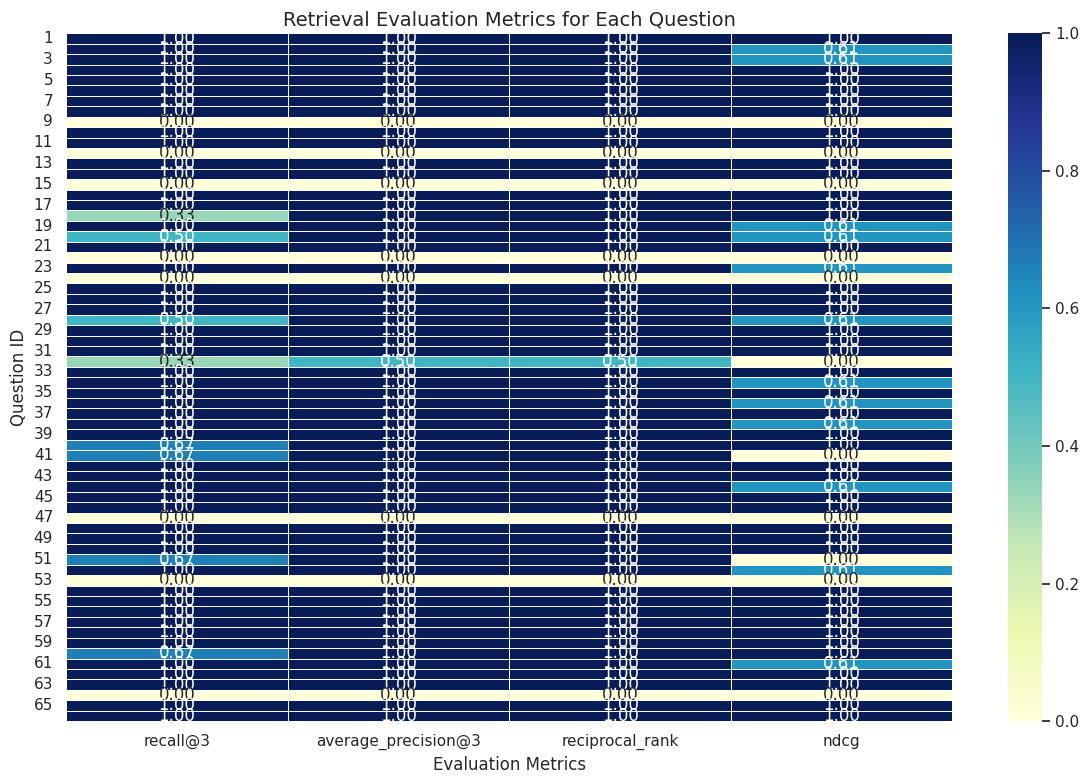

In [33]:

# Visualize the metrics
import matplotlib.pyplot as plt
import seaborn as sns

# Set the chart style
sns.set(style="whitegrid")
plt.figure(figsize=(14, 10))

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Retrieval Evaluation Metrics Visualization', fontsize=16)

# Plot the distribution of each metric
sns.histplot(res_df['recall@3'], kde=True, ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Recall@3 Distribution')
axes[0, 0].set_xlabel('Recall@3')
axes[0, 0].set_ylabel('Frequency')

sns.histplot(res_df['average_precision@3'], kde=True, ax=axes[0, 1], color='lightgreen')
axes[0, 1].set_title('Average Precision@3 Distribution')
axes[0, 1].set_xlabel('Average Precision@3')
axes[0, 1].set_ylabel('Frequency')

sns.histplot(res_df['reciprocal_rank'], kde=True, ax=axes[1, 0], color='salmon')
axes[1, 0].set_title('Reciprocal Rank Distribution')
axes[1, 0].set_xlabel('Reciprocal Rank')
axes[1, 0].set_ylabel('Frequency')

sns.histplot(res_df['ndcg'], kde=True, ax=axes[1, 1], color='mediumpurple')
axes[1, 1].set_title('NDCG Distribution')
axes[1, 1].set_xlabel('NDCG')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Calculate the average score for each metric
metrics_avg = {
    'Average Recall@3': res_df['recall@3'].mean(),
    'Mean Average Precision@3': res_df['average_precision@3'].mean(),
    'Mean Reciprocal Rank': res_df['reciprocal_rank'].mean(),
    'NDCG': res_df['ndcg'].mean()
}

# Display average scores
print("Average scores for each metric:")
for metric, score in metrics_avg.items():
    print(f"{metric}: {score:.4f}")

# Plot bar chart of average scores
plt.figure(figsize=(10, 6))
sns.barplot(x=list(metrics_avg.keys()), y=list(metrics_avg.values()), palette="viridis")
plt.title('Average Scores of Retrieval Evaluation Metrics', fontsize=14)
plt.xlabel('Evaluation Metrics', fontsize=12)
plt.ylabel('Average Score', fontsize=12)
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Display all metrics for each question
plt.figure(figsize=(12, 8))
metrics_df = res_df[['recall@3', 'average_precision@3', 'reciprocal_rank', 'ndcg']]
metrics_df.index = res_df['question_id'] if 'question_id' in res_df.columns else range(1, len(res_df) + 1)

# Plot heatmap
sns.heatmap(metrics_df, annot=True, cmap="YlGnBu", linewidths=.5, fmt=".2f", vmin=0, vmax=1)
plt.title('Retrieval Evaluation Metrics for Each Question', fontsize=14)
plt.xlabel('Evaluation Metrics', fontsize=12)
plt.ylabel('Question ID', fontsize=12)
plt.tight_layout()
plt.show()
